<a href="https://colab.research.google.com/github/clomia/AIB-Section1-Project/blob/master/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('https://drive.google.com/uc?export=download&id=1wH6BUzfoXJx_yrOVNj7Ewt2lFJ5MGIPW')
origin_data = data.copy()

## Pre-processing

### 판매량 데이터 전처리

판매량을 환산하는 함수입니다.  
기본값으로 백만단위를 사용하며, 0으로 표기된것은  
단위에 미치지 못한 0이상의 숫자라고 간주하여 (단위/2)값으로 대체합니다  .
  
( 단위로는 K = 1_000 , M = 1000_000 , 기본 = 1000_000 입니다. )

In [2]:
def numericization(value):
    M = 1000_000
    K = 1_000

    def KM_product(number,unit):
        result = number * unit
        return result if result else unit/2

    logic_dict = {
        'K':lambda value: KM_product( float(value), K ),
        'M':lambda value: KM_product( float(value), M ),
    }
    try:
        result = KM_product( float(value), M )
    except ValueError:
        unit,number = value[-1],value[:-1]
        result = logic_dict[unit](number)
    return np.int64(result)

### 출시년도 데이터 전처리  

연도 데이터에서 잘못된 값과 결측치를 처리합니다. 
   
**잘못된 값 복구**  
잘못된 값은 연도 범위에서 벗어난 두자리 숫자입니다.  
데이터 분석 결과 잘못된 값은 무조건 20이하이거나 80이상입니다.  
또한 올바른 연도데이터가 가지는 범위는 (1980 ~ 2020) 입니다.  
즉, 잘못된 값이 20이하인 경우 2000을 더하고,  
80 이상인 경우 1900을 더해서 올바른 연도로 복구합니다. 
  
**결측치 처리**  
위에서 처리된 데이터의 평균,표준편차,분산을 모방하는  
샘플 데이터셋을 생성하여 결측치를 매꿉니다.  
결과적으로 데이터의 통계치 회손을 최소화합니다.

아래 코드는 간단하게 데이터를 확인하는 작업입니다.

In [3]:
normal_elements , denormal_elements = [] , []


class Filter:
    def __init__(self, normal:bool , container:list):
        self.normal = normal
        self.container = container
    
    def __call__(self,func):
        def wrapper(year):
            return_value = func(year)
            if not return_value:
                if not self.normal:
                    self.container.append(np.nan)
                return
            length,year = return_value
            if self.normal and length == 4:
                self.container.append(year)
            elif (not self.normal) and length != 4:
                self.container.append(year)
            return return_value
        return wrapper

    @staticmethod                
    def function(year):
        try:
            year = np.int64(year)
        except ValueError:
            return 
        else:
            return len(str(year)),year

        
@Filter(normal=True,container=normal_elements)
def normal_sampling(year):
    return Filter.function(year)

@Filter(normal=False,container=denormal_elements)
def denormal_sampling(year):
    return Filter.function(year)


data['Year'].apply(denormal_sampling)
data['Year'].apply(normal_sampling)


# "assertion failed"가 발생하지 않는것을 통해서 NAN이 아닌 비정상적인 년도는 모두 20이하이거나 80이상이라는것을 증명합니다.
filter_20_to_80 = tuple( value for value in denormal_elements if value <= 20 or value >= 80 )
filter_not_nan = tuple( value for value in denormal_elements if value is not np.nan )
assert filter_20_to_80 == filter_not_nan

round_int = lambda number:int(round(number,0))
data_info = {
    '평균':round_int(np.mean(normal_elements)),
    '분산':round_int(np.var(normal_elements)),
    '표준편차':round_int(np.std(normal_elements)),
}
# 평균:2006 , 표준편차:6

missing_values = tuple( object for value in denormal_elements if value is np.nan )
MISSING_VALUE_COUNT = len(missing_values)

print(f'올바른 연도값의 최대와 최소: {min(normal_elements)} , {max(normal_elements)}')
print(f'결측치 갯수:{MISSING_VALUE_COUNT}') # 결측치 갯수: 271개

올바른 연도값의 최대와 최소: 1980 , 2020
결측치 갯수:271


결측치를 매꾸기 위한 샘플 데이터를 생성합니다.  
**기존 데이터의 평균과 표준편차를 모방한 샘플 데이터**를 생성하고 올바른지 테스트합니다.

In [4]:
sampling = lambda : round_int(data_info['표준편차'] * np.random.randn() + data_info['평균'])
sample = [ sampling() for _ in range(MISSING_VALUE_COUNT) ]

print(f"기존 데이터-> 평균:{data_info['평균']} , 분산:{data_info['분산']} , 표준편차:{data_info['표준편차']}")
print(f"새롭게 샘플링된 데이터-> 평균:{round_int(np.mean(sample))} , 분산:{round_int(np.var(sample))} , 표준편차:{round_int(np.std(sample))}")

기존 데이터-> 평균:2006 , 분산:34 , 표준편차:6
새롭게 샘플링된 데이터-> 평균:2006 , 분산:38 , 표준편차:6


위에서 진행한 분석을 기반으로 연도 데이터를 처리하는 함수입니다.

In [5]:
def year_product(value):
    try:
        value = np.int64(value)
    except ValueError:
        value = sample.pop()
        return value if value < 2021 else 2020
    else:
        if 1980 <= value <= 2020:
            return value
        return value + ( 2000 if value <= 20 else 1900 )

### 판매량과 출시년도에 데이터 처리 적용

In [6]:
target = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
data[target] = data[target].applymap(numericization) # 판매 데이터 처리
data.index = data['Year'].apply(year_product) # 출시년도 데이터 처리
data = data.drop(['Unnamed: 0','Year'],axis=1).sort_index(ascending=False) 
data.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Year,,,,,,,,
2020,Imagine: Makeup Artist,DS,Simulation,Ubisoft,270000,500,500000,20000
2020,Twisted Metal: Small Brawl,PS,Action,Unknown,100000,70000,500000,10000
2020,The Golden Compass,Wii,Action,Sega,260000,280000,500000,70000
2020,Reader Rabbit 2nd Grade,Wii,Misc,Unknown,50000,500000,500000,500000
2020,Atsumare! Power Pro Kun no DS Koushien,DS,Sports,NaN,500000,500000,100000,500000


### Genre와 Publisher의 NaN값 대체  
Genre : "Misc"  
Publisher : "Unknown"

In [7]:
genre_missing_data = data['Genre'][ data['Genre'].isin([np.nan]) ]
publisher_missing_data = data['Publisher'][ data['Publisher'].isin([np.nan]) ]

data['Genre'] = data['Genre'].fillna('Misc')
data['Publisher'] = data['Publisher'].fillna('Unknown')

print(f'처리한 NaN 갯수| Genre:{len(genre_missing_data)} , Publisher:{len(publisher_missing_data)}')
data.info()

처리한 NaN 갯수| Genre:50 , Publisher:58
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 2020 to 1980
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16598 non-null  object
 1   Platform     16598 non-null  object
 2   Genre        16598 non-null  object
 3   Publisher    16598 non-null  object
 4   NA_Sales     16598 non-null  int64 
 5   EU_Sales     16598 non-null  int64 
 6   JP_Sales     16598 non-null  int64 
 7   Other_Sales  16598 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 1.1+ MB


## 필수 내용

#### 지역에 따라서 선호하는 게임 장르가 다를까  
North America, European Union, Japan  
  
[PlatForm은 비디오 게임 및 액션 장르의 하위장르이다.](https://en.wikipedia.org/wiki/Platform_game)

Text(0.5, 1.0, 'North America Sales Data')

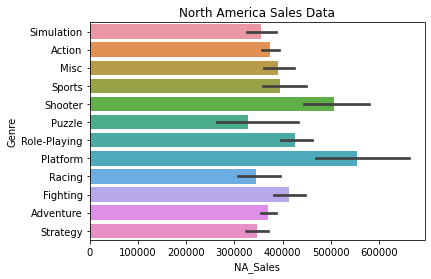

In [8]:
sns.barplot(x="NA_Sales", y="Genre", data=data)
plt.title("North America Sales Data")

Text(0.5, 1.0, 'European Sales Data')

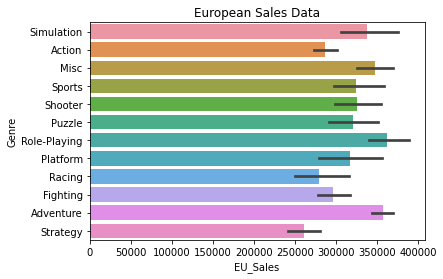

In [9]:
sns.barplot(x="EU_Sales", y="Genre", data=data)
plt.title("European Sales Data")

Text(0.5, 1.0, 'Japan Sales Data')

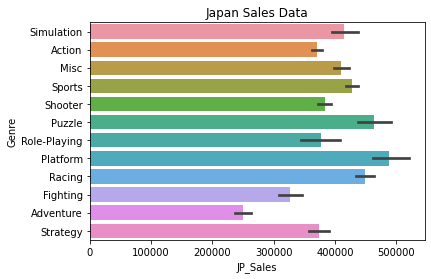

In [10]:
sns.barplot(x="JP_Sales", y="Genre", data=data)
plt.title("Japan Sales Data")

Text(0.5, 1.0, 'Other Sales Data')

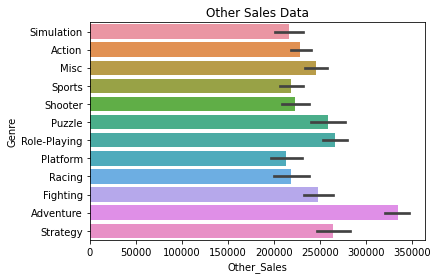

In [11]:
sns.barplot(x="Other_Sales", y="Genre", data=data)
plt.title("Other Sales Data")

#### 연도별 게임의 트렌드가 있을까

#### 출고량이 높은 게임에 대한 분석 및 시각화 프로세스